In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import keras.backend as K
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn

pd.options.display.max_columns = 999

%matplotlib inline

In [4]:
data = pd.read_csv(r'../../output/metrics.csv')
df = pd.DataFrame(data)
df['title'] = df['level_0']
attack_series = []
attack_IDs = []
dimensions_series = []
for _, row in df.iterrows():
    attack_series.append(row['level_1'].split('/')[-2])

df['attack'] = attack_series

for _, row in df.iterrows():
    dimension = int(row['attack'].split('_')[0].replace('p',''))
    dimensions_series.append(dimension)

    if row['attack'] in ['1080p', '720p', '480p', '360p', '240p', '144p']:
            attack_IDs.append(1)
    else:
        attack_IDs.append(0)

df['attack_ID'] = attack_IDs
df['dimension'] = dimensions_series
df = df.drop(['Unnamed: 0',
         'temporal_canny-series',
         'temporal_canny-cosine',
         'temporal_canny-cross-correlation',
         'temporal_cross_correlation-series',
         'temporal_cross_correlation-cosine',
         'temporal_cross_correlation-cross-correlation',
         'temporal_difference-series',
         'temporal_difference-cosine',
         'temporal_difference-cross-correlation',
         'temporal_histogram_distance-series', 
         'temporal_histogram_distance-cosine',
         'temporal_histogram_distance-cross-correlation',
         'temporal_dct-series', 
         'temporal_dct-cosine',
         'temporal_dct-cross-correlation',
         'level_0', 
         'level_1'],axis=1)

# Data Visualization

In [ ]:
df.head(25)

In [ ]:
df.describe()

In [ ]:
df_corr = df.corr()

In [ ]:
plt.figure(figsize=(10,10))
corr = df_corr.drop(['attack_ID'],axis=1).corr('spearman')
corr.style.background_gradient().set_precision(2)

# Define model (Keras neural network)

We choose the input of our model (we try to make balanced dataset)

In [ ]:
int(df.shape[0]*0.8)

In [ ]:
num_train = int(df.shape[0]*0.8)

df_train_all = df[0:num_train]
df_train_1 = df_train_all[df_train_all['attack_ID'] == 1]
df_train_0 = df_train_all[df_train_all['attack_ID'] == 0]
df_sample = df_train_0.sample(df_train_1.shape[0])
df_train = df_train_1.append(df_sample)
df_train = df_train.sample(frac=1)

df_test_all = df[num_train:]
df_test_1 = df_test_all[df_test_all['attack_ID'] == 1]
df_test_0 = df_test_all[df_test_all['attack_ID'] == 0]
df_sample_test = df_test_0.sample(df_test_0.shape[0])
df_test = df_test_1.append(df_sample_test)
df_test = df_test.sample(frac=1)

X_train = df_train.drop(['title',
                         'attack', 
                         'attack_ID',
                         'vmaf'],axis=1)
y_train = df_train['attack_ID']
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = df_test.drop(['title',  
                     'attack', 
                     'attack_ID',
                     'vmaf'],axis=1)
y_test = df_test['attack_ID']
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)



First we define a model where we take all variables :

In [ ]:
print('TRAIN:', X_train.shape)
print('TEST:', X_test.shape)

In [ ]:
def model():
    global network_history
    model = Sequential()
    model.add(Dense(64,input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(128, kernel_initializer='glorot_uniform', activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(256, kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(256, kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(256, kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(128, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(128,kernel_initializer= "uniform", bias_initializer="zeros",activation= "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16,kernel_initializer= "uniform", bias_initializer="zeros",activation= "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    
    network_history = model.fit(X_train, y_train, batch_size=128, epochs=1000, verbose=0)
    return model

model = model()

visualization loss and accuracy

In [ ]:
print(model.metrics_names)

In [ ]:
def plot_history(network_history,title='Loss and accuracy (Keras model)'):
    plt.figure(figsize=(15,10))
    plt.subplot(211)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    #plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.subplot(212)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    #plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [ ]:
plot_history(network_history)

In [ ]:
print(model.metrics_names)
model.evaluate(X_test, y_test)


In [ ]:
def plot_roc(fpr, tpr, title):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
prediction = model.predict(X_test)

In [ ]:
prediction_bin = prediction > 0.5
prediction_bin = prediction_bin.astype(int)
confusion_matrix(y_test, prediction_bin)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, prediction)
print('TNR={}, TPR={}'.format(1-np.mean(fpr),np.mean(tpr)))
plot_roc(fpr, tpr, 'Neural network')

Test only with Class : 0

In [ ]:
df_test_0_only = df_test_0.sample(100)
X_test_0 = df_test_0_only.drop(['title', 
                                 'attack', 
                                 'attack_ID',
                                 'vmaf'], axis=1)
y_test_0 = df_test_0_only['attack_ID']
X_test_0 = np.asarray(X_test_0)
y_test_0 = np.asanyarray(y_test_0)

In [ ]:
model.evaluate(X_test_0, y_test_0)

In [ ]:
prediction_0 = model.predict(X_test_0)
prediction_0_bin = prediction_0 > 0.5
prediction_0_bin = prediction_0_bin.astype(int)
confusion_matrix(y_test_0, prediction_0_bin)

In [ ]:
X_test_all = df_test_all.drop(['title', 
                             'attack', 
                             'attack_ID',
                             'vmaf'],axis=1)
y_test_all = df_test_all['attack_ID']
X_test_all = np.asarray(X_test_all)
y_test_all = np.asarray(y_test_all)
display(y_test_all)

In [ ]:
model.evaluate(X_test_all,y_test_all)

In [ ]:
prediction_NN_all = model.predict(X_test_all)
prediction_NN_train = model.predict(X_train)

In [ ]:
prediction_all_bin = prediction_NN_all > 0.5
prediction_NN_all_bin = prediction_NN_all.astype(int)
confusion_matrix(y_test_all, prediction_NN_all_bin)

In [ ]:
fpr, tpr, _ = roc_curve(y_test_all, prediction_NN_all)
print('TNR={}, TPR={}'.format(1-np.mean(fpr),np.mean(tpr)))
plot_roc(fpr, tpr, 'Neural network')

# Random forest with scikit-learn

In [ ]:
random_forest = RandomForestClassifier(n_estimators=15,)
random_forest.fit(X_train,y_train)

In [ ]:
random_forest.score(X_test,y_test)

In [ ]:
prediction_RF = random_forest.predict(X_test)

In [ ]:
confusion_matrix(y_test, prediction_RF)

In [ ]:
random_forest.score(X_test_0,y_test_0)

In [ ]:
prediction_RF_0 = random_forest.predict(X_test_0)
confusion_matrix(y_test_0,prediction_RF_0)

In [ ]:
random_forest.score(X_test_all,y_test_all)

In [ ]:
prediction_RF_all = random_forest.predict(X_test_all)
confusion_matrix(y_test_all, prediction_RF_all)

In [ ]:
fpr, tpr, _ = roc_curve(y_test_all, prediction_RF_all)
print('TNR={}, TPR={}'.format(1-fpr[1],tpr[1]))
plot_roc(fpr, tpr, 'Random Forest')

# AdaBoost with scikit-learn

In [ ]:
AdaBoost = AdaBoostClassifier(learning_rate=0.1)
AdaBoost.fit(X_train, y_train)

In [ ]:
AdaBoost.score(X_test, y_test)

In [ ]:
prediction_AdaBoost = AdaBoost.predict(X_test)

In [ ]:
confusion_matrix(y_test, prediction_AdaBoost)

In [ ]:
AdaBoost.score(X_test_0,y_test_0)

In [ ]:
prediction_AdaBoost_0 = AdaBoost.predict(X_test_0)
confusion_matrix(y_test_0,prediction_AdaBoost_0)

In [ ]:
AdaBoost.score(X_test_all,y_test_all)

In [ ]:
prediction_AdaBoost_all = AdaBoost.predict(X_test_all)
confusion_matrix(y_test_all, prediction_AdaBoost_all)

In [ ]:
fpr, tpr, _ = roc_curve(y_test_all, prediction_AdaBoost_all)
print('TNR={}, TPR={}'.format(1-fpr[1],tpr[1]))
plot_roc(fpr, tpr, 'AdaBoost')

# SVM with scikit-learn

In [ ]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler().fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
classifier = svm.SVC(kernel='rbf')
classifier.fit(X_train, y_train)
prediction_SVM = classifier.predict(X_test)

In [ ]:
classifier.score(X_test,y_test)

In [ ]:
confusion_matrix(y_test, prediction_SVM)

In [ ]:
classifier.score(X_test_0,y_test_0)

In [ ]:
prediction_SVM_0 = classifier.predict(X_test_0)
confusion_matrix(y_test_0,prediction_SVM_0)

In [ ]:
classifier.score(X_test_all,y_test_all)

In [ ]:
prediction_SVM_all = classifier.predict(X_test_all)
confusion_matrix(y_test_all, prediction_SVM_all)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, prediction_SVM)
print('TNR={}, TPR={}'.format(1-fpr[1],tpr[1]))
plot_roc(fpr, tpr, 'SVM')

# XGBoost

In [5]:
import xgboost as xgb

In [14]:
classifier = xgb.XGBClassifier()
classifier.fit(X_train, y_train)
prediction_XGB = classifier.predict(X_test)

In [15]:
classifier.score(X_test,y_test)

0.8732758620689656

In [17]:
confusion_matrix(y_test, prediction_XGB)

array([[856, 139],
       [  8, 157]])

In [21]:
classifier.score(X_test_0,y_test_0)

1.0

In [26]:
prediction_XGB_0 = classifier.predict(X_test_0)
confusion_matrix(y_test_0,prediction_XGB_0)

array([[100]])

In [27]:
classifier.score(X_test_all,y_test_all)

0.8577586206896551

In [30]:
prediction_XGB_all = classifier.predict(X_test_all)
confusion_matrix(y_test_all, prediction_XGB_all)

array([[995,   0],
       [165,   0]])

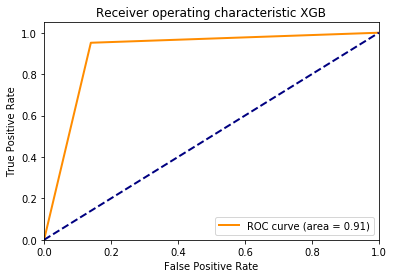

In [32]:
fpr, tpr, _ = roc_curve(y_test, prediction_XGB)
plot_roc(fpr, tpr, 'XGB')